<a href="https://colab.research.google.com/github/huggingface/notebooks/blob/main/diffusers/in_painting_with_stable_diffusion_using_diffusers.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# In-painting pipeline for Stable Diffusion using 🧨 Diffusers 

This notebook shows how to do text-guided in-painting with Stable Diffusion model using  🤗 Hugging Face [🧨 Diffusers library](https://github.com/huggingface/diffusers). 

For a general introduction to the Stable Diffusion model please refer to this [colab](https://colab.research.google.com/github/huggingface/notebooks/blob/main/diffusers/stable_diffusion.ipynb).

In [2]:
!pip install -qq -U diffusers==0.11.1 transformers ftfy gradio accelerate

To use private and gated models on 🤗 Hugging Face Hub, login is required. If you are only using a public checkpoint (such as `runwayml/stable-diffusion-inpainting` in this notebook), you can skip this step.

In [3]:
from huggingface_hub import notebook_login

notebook_login()

In [4]:
import inspect
from typing import List, Optional, Union

import numpy as np
import torch

import PIL
import gradio as gr
from diffusers import StableDiffusionInpaintPipeline

In [5]:
device = "cuda"
model_path = "runwayml/stable-diffusion-inpainting"

pipe = StableDiffusionInpaintPipeline.from_pretrained(
    model_path,
    torch_dtype=torch.float16,
).to(device)

C:\Users\noteh\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\huggingface_hub\file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


model_index.json:   0%|          | 0.00/548 [00:00<?, ?B/s]

C:\Users\noteh\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\huggingface_hub\file_download.py:157: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\noteh\.cache\huggingface\diffusers\models--runwayml--stable-diffusion-inpainting. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to see activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)
v

Fetching 24 files:   0%|          | 0/24 [00:00<?, ?it/s]

pytorch_model.fp16.bin:   0%|          | 0.00/608M [00:00<?, ?B/s]

model.fp16.safetensors:   0%|          | 0.00/608M [00:00<?, ?B/s]

text_encoder/config.json:   0%|          | 0.00/617 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/748 [00:00<?, ?B/s]

scheduler/scheduler_config.json:   0%|          | 0.00/313 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/1.22G [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/492M [00:00<?, ?B/s]

(…)ature_extractor/preprocessor_config.json:   0%|          | 0.00/342 [00:00<?, ?B/s]

pytorch_model.fp16.bin:   0%|          | 0.00/246M [00:00<?, ?B/s]

model.fp16.safetensors:   0%|          | 0.00/246M [00:00<?, ?B/s]

safety_checker/config.json:   0%|          | 0.00/4.78k [00:00<?, ?B/s]

tokenizer/merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

tokenizer/special_tokens_map.json:   0%|          | 0.00/472 [00:00<?, ?B/s]

tokenizer/tokenizer_config.json:   0%|          | 0.00/806 [00:00<?, ?B/s]

tokenizer/vocab.json:   0%|          | 0.00/1.06M [00:00<?, ?B/s]

unet/config.json:   0%|          | 0.00/748 [00:00<?, ?B/s]

diffusion_pytorch_model.bin:   0%|          | 0.00/3.44G [00:00<?, ?B/s]

diffusion_pytorch_model.fp16.bin:   0%|          | 0.00/1.72G [00:00<?, ?B/s]

diffusion_pytorch_model.fp16.safetensors:   0%|          | 0.00/1.72G [00:00<?, ?B/s]

vae/config.json:   0%|          | 0.00/552 [00:00<?, ?B/s]

diffusion_pytorch_model.bin:   0%|          | 0.00/335M [00:00<?, ?B/s]

diffusion_pytorch_model.fp16.bin:   0%|          | 0.00/167M [00:00<?, ?B/s]

diffusion_pytorch_model.fp16.safetensors:   0%|          | 0.00/167M [00:00<?, ?B/s]

In [6]:
import requests
from io import BytesIO

def image_grid(imgs, rows, cols):
    assert len(imgs) == rows*cols

    w, h = imgs[0].size
    grid = PIL.Image.new('RGB', size=(cols*w, rows*h))
    grid_w, grid_h = grid.size
    
    for i, img in enumerate(imgs):
        grid.paste(img, box=(i%cols*w, i//cols*h))
    return grid


def download_image(url):
    response = requests.get(url)
    return PIL.Image.open(BytesIO(response.content)).convert("RGB")

img_url = "https://raw.githubusercontent.com/CompVis/latent-diffusion/main/data/inpainting_examples/overture-creations-5sI6fQgYIuo.png"
mask_url = "https://raw.githubusercontent.com/CompVis/latent-diffusion/main/data/inpainting_examples/overture-creations-5sI6fQgYIuo_mask.png"

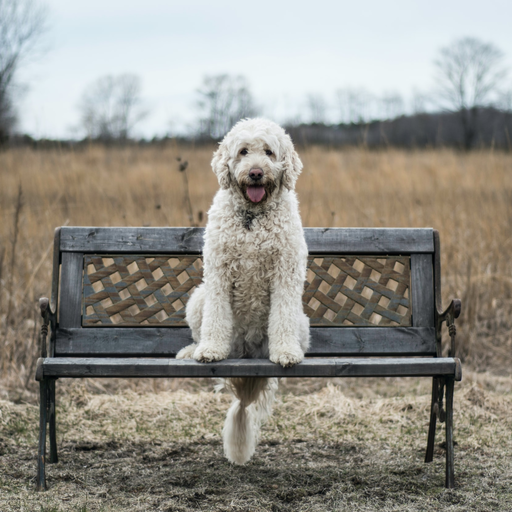

In [7]:
image = download_image(img_url).resize((512, 512))
image

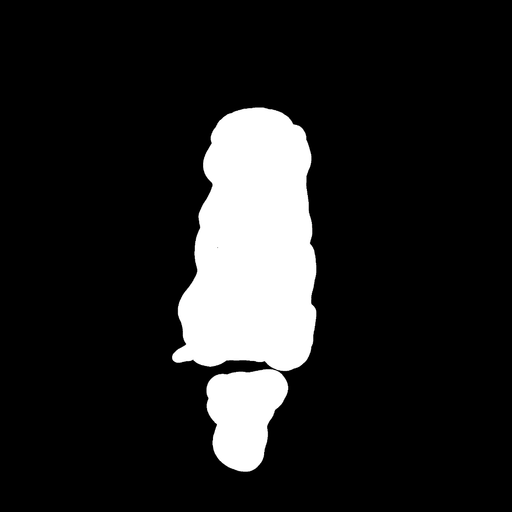

In [8]:
mask_image = download_image(mask_url).resize((512, 512))
mask_image

In [9]:
prompt = "a mecha robot sitting on a bench"

guidance_scale=7.5
num_samples = 3
generator = torch.Generator(device="cuda").manual_seed(0) # change the seed to get different results

images = pipe(
    prompt=prompt,
    image=image,
    mask_image=mask_image,
    guidance_scale=guidance_scale,
    generator=generator,
    num_images_per_prompt=num_samples,
).images

  0%|          | 0/50 [00:00<?, ?it/s]

In [10]:
# insert initial image in the list so we can compare side by side
images.insert(0, image)

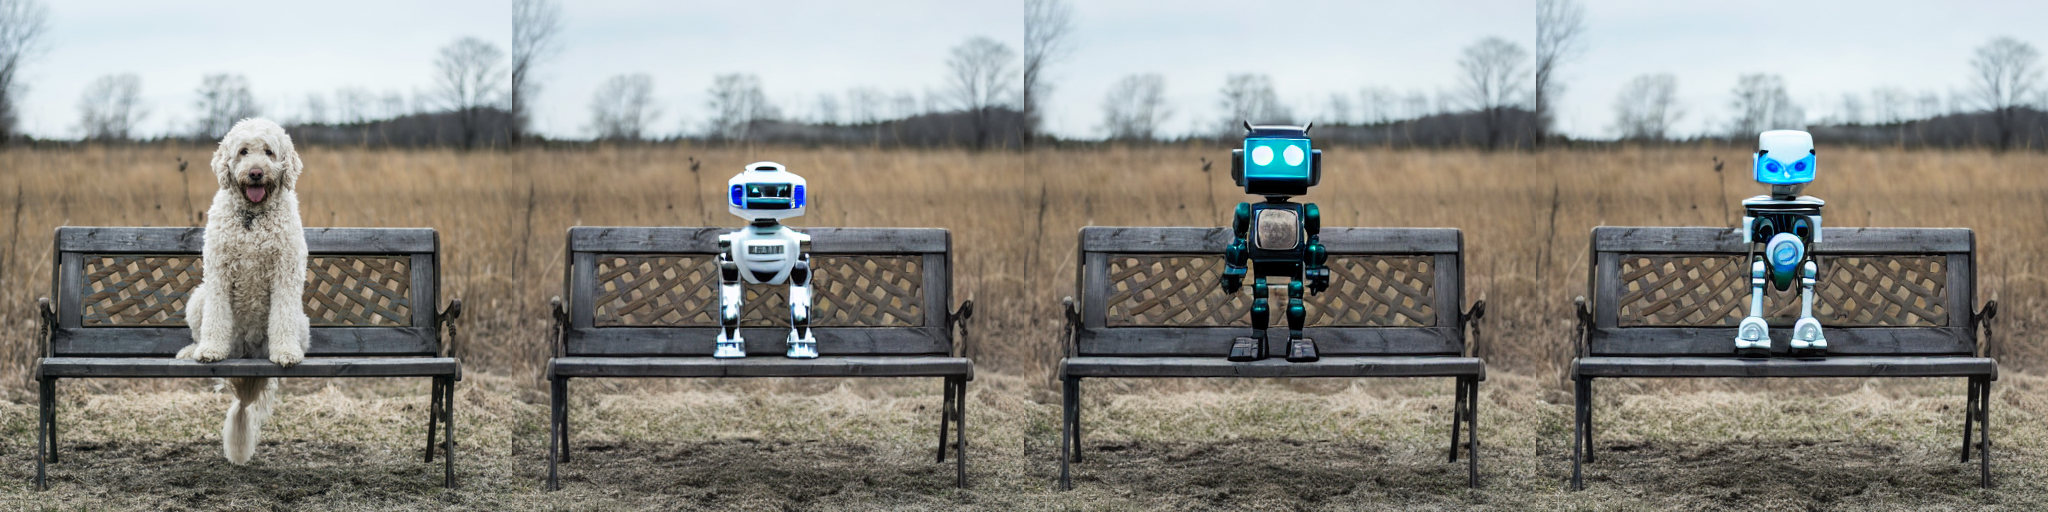

In [11]:
image_grid(images, 1, num_samples + 1)

### Gradio Demo

In [12]:
def predict(dict, prompt):
  image =  dict['image'].convert("RGB").resize((512, 512))
  mask_image = dict['mask'].convert("RGB").resize((512, 512))
  images = pipe(prompt=prompt, image=image, mask_image=mask_image).images
  return(images[0])

In [19]:
gr.Interface(
    predict,
    title = 'Stable Diffusion In-Painting',
    inputs=[
        #gr.Image(source = 'upload', tool = 'sketch', type = 'pil'),
        gr.ImageEditor(sources='upload', type='pil'),
        gr.Textbox(label = 'prompt')
    ],
    outputs = [
        gr.Image()
        ]
).launch(debug=True)

Running on local URL:  http://127.0.0.1:7860

To create a public link, set `share=True` in `launch()`.


Keyboard interruption in main thread... closing server.
